In [1]:
# Importando bibliotecas
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [19]:
# Inicializando dataset e visualizando itens
df = pd.read_csv('credit_card_fraud_detection.csv')
df.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date,Merchant Name,Merchant Category,Country,Card Type,Fraudulent,Transaction Method,User Age,User Gender,Account Balance,Transaction Time,Transaction Location
0,T00001,U0001,21.62,2022-10-19,Walmart,Health & Wellness,USA,Credit,No,Online,71,Non-Binary,25786.02,08:27,Rural
1,T00002,U0002,76.66,2023-03-10,Apple Store,Health & Wellness,India,Prepaid,No,Online,80,Non-Binary,25347.05,17:58,Suburban
2,T00003,U0003,494.52,2023-01-14,Best Buy,Retail,Germany,Credit,No,In-Store,48,Male,38215.24,09:28,Rural
3,T00004,U0004,300.03,2023-11-04,Apple Store,Travel,Australia,Credit,Yes,ATM Withdrawal,70,Male,34663.70,09:00,Urban
4,T00005,U0005,746.05,2023-05-12,Starbucks,Electronics,South Africa,Debit,No,Online,30,Male,8763.38,03:24,Suburban


In [95]:
# Criando função auxiliar para desenhar grafos
def criar_grafo(df, pais):
    grafo = nx.Graph()
    grafo.add_node(pais)

    # Inserindo vértices e arestas
    for i in range(len(df)):
        if df.iloc[i]['Country'] == pais:
            user_id = df.iloc[i]['User ID']
            transaction_amount = df.iloc[i]['Transaction Amount']
            grafo.add_node(user_id)
            grafo.add_edge(user_id, pais, weight=transaction_amount)

    # Dimensionando figura e ajustando cores
    plt.figure(figsize = (8, 4))
    cor = ['orange' if node == pais else 'teal' for node in grafo.nodes()]

    # Dando nome e visualizando grafo
    nx.draw(grafo, with_labels = True, node_color = cor, edge_color = "gray", font_size = 10, node_size = 1000)
    plt.title(f"Fraudulent graphs in {pais}")
    plt.show()

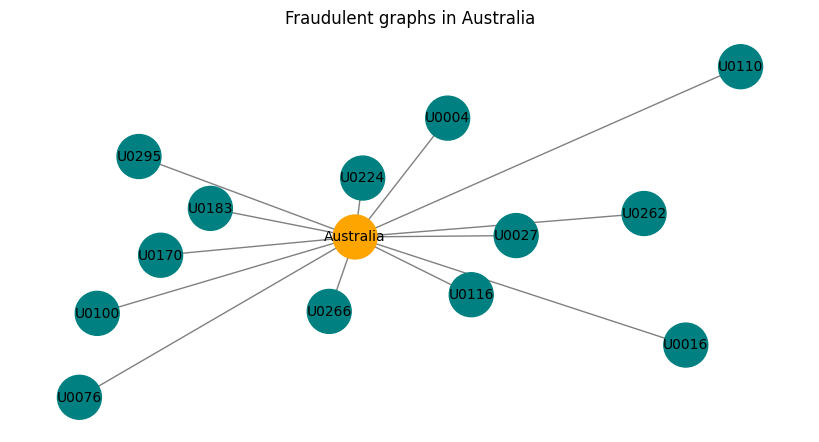

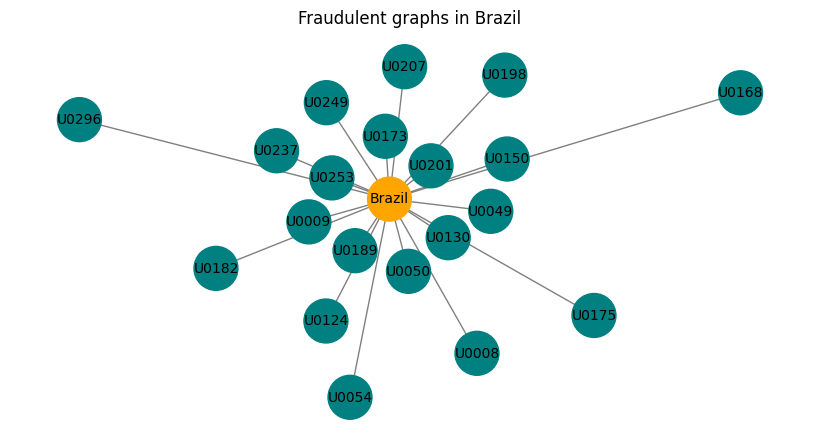

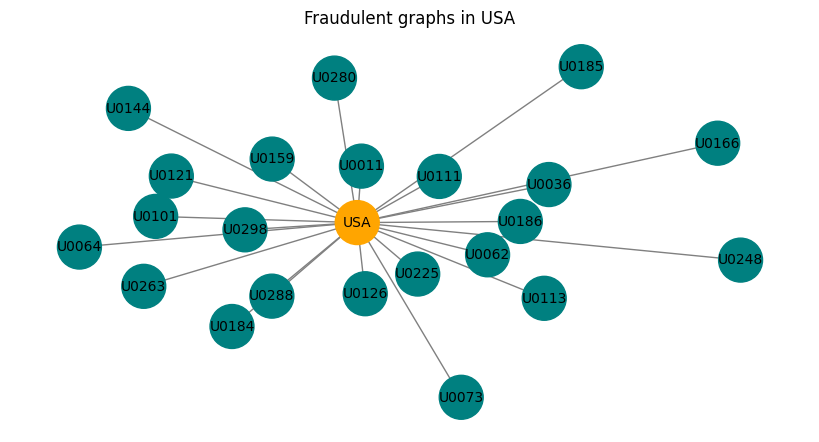

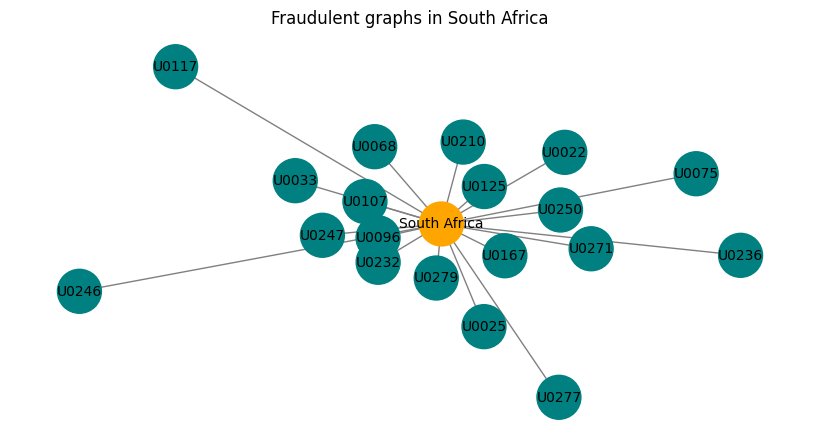

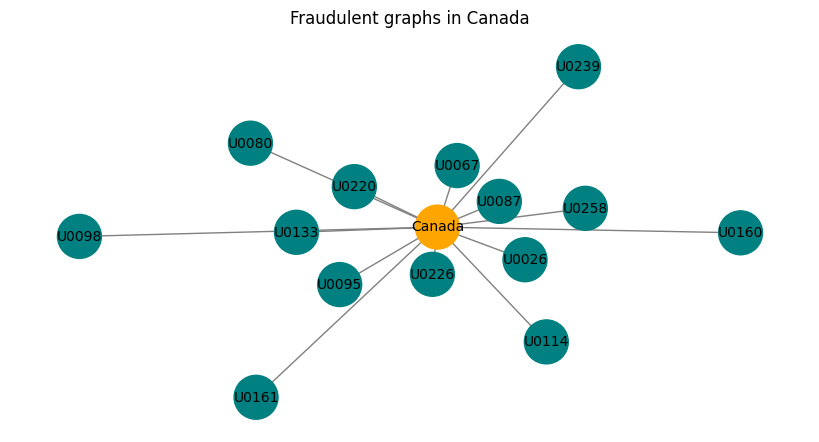

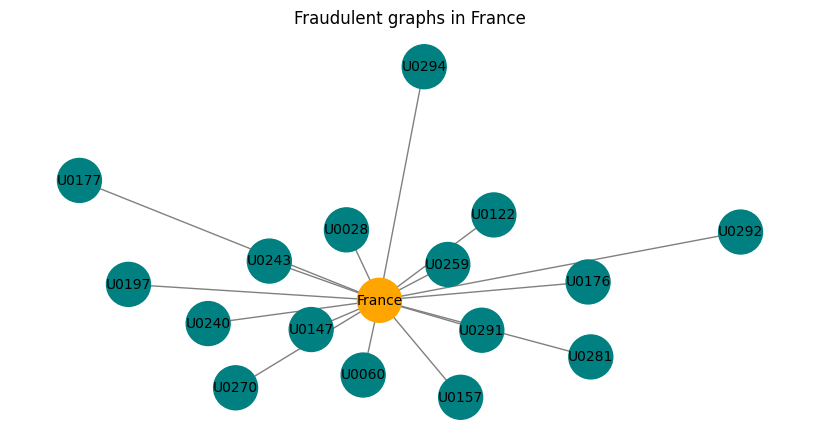

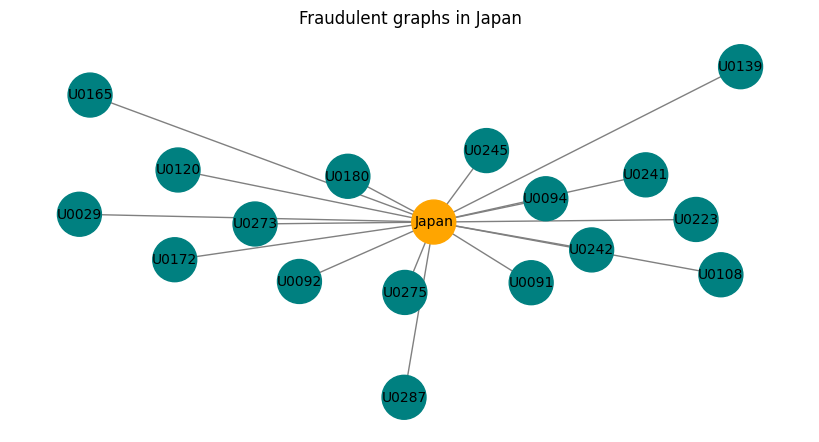

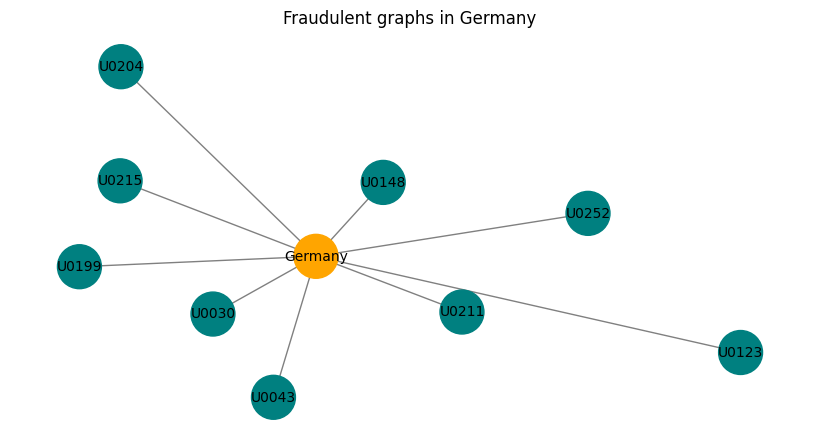

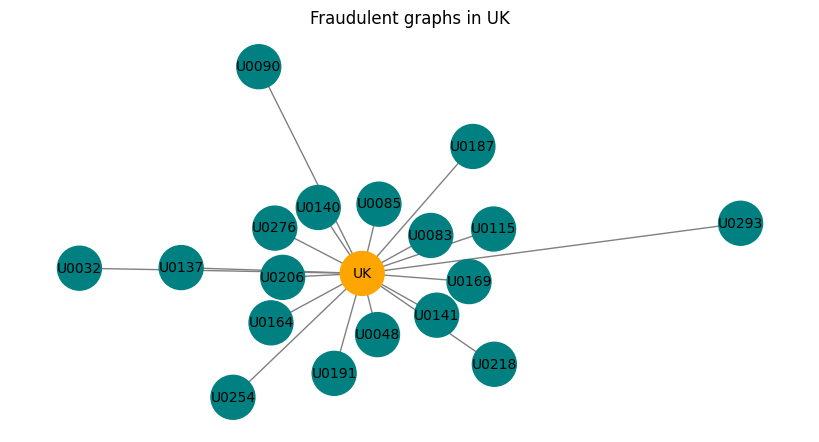

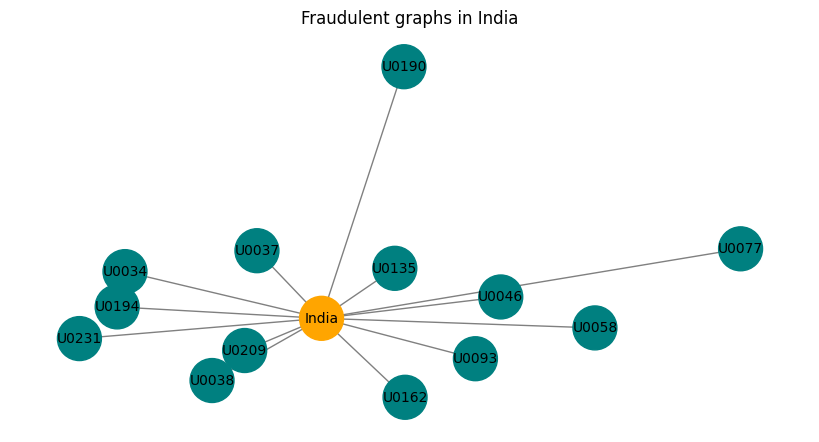

In [96]:
df_fraudulento = df[df['Fraudulent'] == 'Yes']
paises = df_fraudulento['Country'].unique()

for pais in paises:
    criar_grafo(df_fraudulento, pais)